## **Spatial Clustering of Molecular Localizations Using MIRO**

This tutorial demonstrates how to train and apply **MIRO** to cluster spatial point clouds obtained from single-molecule localization microscopy (SMLM). Specifically, we show how to use MIRO on benchmark data introduced in [Nieves et al., *Nature Methods* (2023)](https://www.nature.com/articles/s41592-022-01750-6), which provides a standardized framework for evaluating clustering methods in SMLM.


### **1. Download the data**


To begin, download the benchmark dataset using the `sdownload` function. 

This function requires three parameters: `id`, which specifies the dataset to download (in this case, `id=6`); `local_folder`, the target directory where the data will be stored; and `blinking`, a boolean indicating whether to include fluorophore blinking effects. 

The function returns the path to the downloaded dataset, which will be used for training and evaluation.


In [7]:
import sys
from pathlib import Path

# Ensure the library path is in sys.path
lib_path = Path.cwd().parent.resolve()

if str(lib_path) not in sys.path:
    sys.path.insert(0, str(lib_path))

import lib

BLINKING = False
#path = lib.sdownload(id=6, local_folder="data", blinking=BLINKING)

current_path = Path.cwd()
path = current_path / "csv_generats"


Next, we load the training data and extract a small set of representative clusters for training. 

One of **MIRO**’s key advantages is its ability to learn effectively from limited data, typically requiring only a few dozen well-chosen clusters to generalize successfully.

In this tutorial, we use clusters extracted from just 3 out of the 50 available images in the dataset.

In [23]:
from pathlib import Path
import re
import json
import pandas as pd

data_dir = path
csv_files = sorted(path.glob("*.csv"), key=lambda x: int(re.findall(r'\d+', x.stem)[0]))
# Load the metadata associated with the dataset
metadata = {
    "csv_generats": {
        "training_indices": list(range(1, int(len(csv_files)*0.8)))
    ,"builder": "GraphDataset",
    "builder_kwargs": {},

    "recurrent_iterations": 3,

    "checkpoint": "checkpoint.pt",

    "MIRO_DBSCAN_params": {
        "eps": 0.5,
        "min_samples": 5
    },

    "DBSCAN_params": {
        "eps": 0.05,
        "min_samples": 5
    }
}}

metadata = metadata[data_dir.name]
training_indices = metadata["training_indices"]
training_paths = [csv_files[i - 1] for i in training_indices]

training_clusters, training_backgrounds = [], []
for csv_path in training_paths:
    df = pd.read_csv(csv_path)

    # Normalize coordinates to [0, 1]
    coords = df[["x", "y"]]
    mins, maxs = coords.min(), coords.max()
    df[["x", "y"]] = (coords - mins) / (maxs - mins)

    # Group by 'index'
    for idx, group in df.groupby("index"):
        # 0 (the background)
        if idx == 0:
            training_backgrounds.append(group[["x", "y"]].values)
        else:
            centered = group[["x", "y"]] - group[["x", "y"]].mean()
            training_clusters.append(centered)

print("METADATA =", metadata)
print("KEYS =", metadata.keys())

METADATA = {'training_indices': [1, 2, 3, 4, 5, 6, 7], 'builder': 'GraphDataset', 'builder_kwargs': {}, 'recurrent_iterations': 3, 'checkpoint': 'checkpoint.pt', 'MIRO_DBSCAN_params': {'eps': 0.5, 'min_samples': 5}, 'DBSCAN_params': {'eps': 0.05, 'min_samples': 5}}
KEYS = dict_keys(['training_indices', 'builder', 'builder_kwargs', 'recurrent_iterations', 'checkpoint', 'MIRO_DBSCAN_params', 'DBSCAN_params'])


### **2. Build the training dataset**


**MIRO** employs an augmentation pipeline that transforms the small set of training cluster into a large number of diverse point clouds for training. 

Each point cloud is generated by applying a series of transformations to randomly selected clusters, including geometric transformations (rotations, reflections), stochastic perturbations (localization dropout or addition), and spatial jitter (small random displacements).  These transformed clusters are then randomly placed within a synthetic FOV to generate the final training samples.


The following code initializes the **MIRO** data builder, which generates the augmented training dataset based on the extracted clusters and a set of metadata parameters. These metadata settings define key aspects of the synthetic dataset, such as the number of generated samples, the range of background noise points, the number of clusters per FOV, and the spatial connectivity radius used to define cluster compactness. 

You can inspect these settings by printing `metadata["builder_kwargs"]`. Once initialized, calling the builder returns a fully augmented dataset ready for training.


In [24]:
# Initialize the MIRO builder with the training clusters and metadata
builder_args = (training_clusters,)
if BLINKING:
    builder_args += (training_backgrounds,)
    
builder = getattr(lib, metadata["builder"])(
    *builder_args, **metadata["builder_kwargs"]
)
augmented_dataset = builder()

  0%|          | 0/1924 [00:00<?, ?it/s]

Generating dataset:   0%|          | 0/512 [00:00<?, ?it/s]

Let’s take a closer look at one of the augmented training images.

In **MIRO**, each training sample is represented as a **graph**, where nodes correspond to individual molecular localizations and edges are defined via Delaunay triangulation to capture local spatial relationships. You can use the following code to visualize one of these examples.

The colormap in the labeled scatter plot represents the magnitude of the **displacement vectors** from each node to its assigned cluster center. These vectors serve as the ground truth during training, enabling **MIRO** to learn transformations that contract structures toward a common center, effectively modeling the underlying cluster geometry.


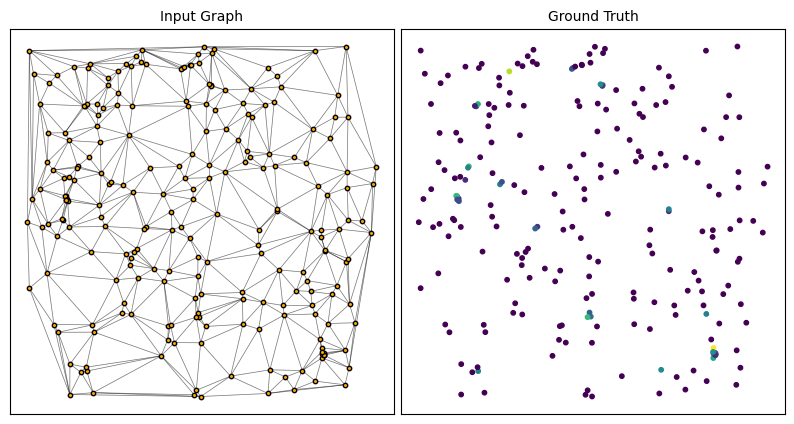

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training_data(sample_idx):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    data = augmented_dataset[sample_idx]

    # Plot the graph representation
    for edge in data["edge_index"].T:
        x = [data["position"][edge[0]][0], data["position"][edge[1]][0]]
        y = [data["position"][edge[0]][1], data["position"][edge[1]][1]]
        ax[0].plot(x, y, color="black", linewidth=0.5, alpha=0.3)
    ax[0].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        s=10,
        zorder=2,
        c="orange",
        edgecolors="black",
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title("Input Graph", fontsize=10)

    # Plot the ground truth displacement vectors
    ax[1].scatter(
        data["position"][:, 0],
        data["position"][:, 1],
        c=np.linalg.norm(data["y"], axis=1),
        s=10,
    )
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Ground Truth", fontsize=10)

    plt.subplots_adjust(wspace=0.02)
    plt.show()


random_sample_idx = np.random.randint(0, len(augmented_dataset))
plot_training_data(random_sample_idx)

### **3. Create the model**


Now, instantiate **MIRO** using the configuration that matches the training data. 

The model is initialized with a set of key parameters: the number of output features (in this case, 2 for the predicted *x* and *y* displacements), the connectivity radius used to construct the input graphs (which should match the one used during augmentation), and the number of recurrent message-passing iterations to apply on the input graphs (set to 20 by default).

In [26]:
import deeplay as dl

clusterer = dl.MIRO(
    num_outputs=2,  # Number of output features (e.g., x, y displacements)
    connectivity_radius=builder.connectivity_radius,  # Radius for graph connectivity (matches dataset)
    num_iterations=metadata["recurrent_iterations"],  # Number of iterations for graph processing
)
clusterer = clusterer.create()

print(clusterer)

MIRO(
  (model): RecurrentMessagePassingModel(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            (activation): Identity()
          )
        )
      )
    )
    (backbone): RecurrentGraphBlock(
      (combine): CatDictElements()
      (layer): Sequential(
        (0): Parallel(
          (0-1): 2 x MultiLayerPerceptron(
            (blocks): LayerList(
              (0): LinearBlock(
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
                (activation): Identity()
              )
            )
          )
        )
        (1): MessagePassingNeuralNetwork(
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Transform(
                (combine): Cat()
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
             

### **4. Train the model**


Set up the data loaders and configure the training parameters.

In [27]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(
    dataset=augmented_dataset,  # The dataset to be loaded
    batch_size=4,  # Number of samples per batch
    shuffle=True,  # Shuffle the dataset at every epoch
)

# Initialize the trainer
trainer = dl.Trainer(max_epochs=1)  # Maximum number of training epochs

C:\Users\bertg\AppData\Local\Temp\ipykernel_26824\720576248.py:3: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(


Finally, train **MIRO**. 

Alternatively, you can load a pre-trained model by setting `train_model = False`.

In [28]:
import torch

train_model = True

if train_model:
    trainer.fit(
        clusterer,  # The MIRO model to be trained
        train_loader,  # The DataLoader providing the training data
    )
else:
    clusterer.load_state_dict(torch.load(metadata["checkpoint"]))

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                         ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model         │ RecurrentMessagePassingModel │    514 │ train │     0 │
│ 1 │ loss          │ L1Loss                       │      0 │ eval  │     0 │
│ 2 │ train_metrics │ MetricCollection             │      0 │ train │     0 │
│ 3 │ val_metrics   │ MetricCollection             │      0 │ train │     0 │
│ 4 │ test_metrics  │ MetricCollection             │      0 │ train │     0 │
│ 5 │ optimizer     │ Adam                         │      0 │ train │     0 │
└───┴───────────────┴──────────────────────────────┴────────┴───────┴───────┘

Trainable params: 514                                                                                              
Non-trainable params: 0                                                                                            
Total params: 514                                                                                                  
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 48                                                                                          
Modules in eval mode: 1                                                                                            
Total FLOPs: 0

Output()

c:\Users\bertg\OneDrive\Escritorio\TFG\env_tfg\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:534: Found 1 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


### **5. Test the model**


Once training is complete, it’s time to evaluate **MIRO** on the validation dataset.

The following code reads the validation set and applies the trained model to perform clustering. The `clusterer` object includes a built-in `.clustering()` method, which automates the full inference pipeline. This method applies MIRO to each input graph, transforms the node features into the learned **squeezed representation** (where localizations belonging to the same cluster are pulled toward a common center) and runs DBSCAN on this transformed space to produce the final cluster assignments.


In [29]:
from sklearn.cluster import DBSCAN

clusterer.eval()
clusterer.to("cuda" if torch.cuda.is_available() else "cpu")

validation_paths = [path for path in csv_files if path not in training_paths]

vresults = []
print("Número total CSV:", len(csv_files))
print("Training paths:", len(training_paths))
print("Validation paths:", len(validation_paths))
print(validation_paths)

for i, vpath in enumerate(validation_paths):
    vdata = pd.read_csv(vpath).copy()
    val_graph = lib.compute_test_graph(vdata, builder)

    clusters = clusterer.clustering(
        val_graph,  # Input graph representing the validation point cloud
        eps=metadata["MIRO_DBSCAN_params"][
            "eps"
        ],  # DBSCAN epsilon parameter for neighborhood radius
        min_samples=metadata["MIRO_DBSCAN_params"][
            "min_samples"
        ],  # DBSCAN minimum samples parameter for core points
        scaling=vdata[["x", "y"]]
        .max()
        .values,  # Used to convert displacements back to the original coordinate scale
    )

    dbclusters = DBSCAN(
        eps=metadata["DBSCAN_params"]["eps"],
        min_samples=metadata["DBSCAN_params"]["min_samples"],
    ).fit_predict(vdata[["x", "y"]])

    vdata["clustering-MIRO"] = clusters + 1
    vdata["clustering-DBSCAN"] = dbclusters + 1
    vdata["set"] = i
    vresults.append(vdata)

vresults = pd.concat(vresults, ignore_index=True)

Número total CSV: 10
Training paths: 7
Validation paths: 3
[WindowsPath('c:/Users/bertg/OneDrive/Escritorio/TFG/miro_multiscale_tutorial/MIRO/benchmark/csv_generats/simulated_clusters_8.csv'), WindowsPath('c:/Users/bertg/OneDrive/Escritorio/TFG/miro_multiscale_tutorial/MIRO/benchmark/csv_generats/simulated_clusters_9.csv'), WindowsPath('c:/Users/bertg/OneDrive/Escritorio/TFG/miro_multiscale_tutorial/MIRO/benchmark/csv_generats/simulated_clusters_10.csv')]


Let’s now compute the average evaluation metrics across the 47 validation images. These include `ARI_values` and `AMI_values`, along with class-imbalance-aware variants such as `ARI_c_values` and `ARI_dagger_values`. We also report `IoU_values` to assess cluster overlap, as well as cluster-level metrics like `JIc_values`, `RMSRE_N_values`, and `RMSE_centr_values`.


In [30]:
results = lib.calculate_metrics_for_experiments(vresults)
aresults = results.groupby('class_names').mean().reset_index().round(2)

aresults = aresults.drop(columns=['experiment'])
aresults = aresults.set_index('class_names').transpose()
aresults.columns.name = None

print("Average Results:")
print(aresults)

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\bertg\OneDrive\Escritorio\TFG\miro_multiscale_tutorial\MIRO\lib\metrics.py:265: RuntimeWarning: invalid value encountered in scalar divide
  (
c:\Users\bertg\OneDrive\Escritorio\TFG\env_tfg\Lib\site-packages\numpy\_core\fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bertg\OneDrive\Escritorio\TFG\env_tfg\Lib\site-packages\numpy\_core\_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\bertg\OneDrive\Escritorio\TFG\miro_multiscale_tutorial\MIRO\lib\metrics.py:265: RuntimeWarning: invalid value encountered in scalar divide
  (
c:\Users\bertg\OneDrive\Escritorio\TFG\env_tfg\Lib\site-packages\numpy\_core\fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bertg\OneDrive\Escritorio\TFG\env_tfg\Lib\site-packages\numpy\_core\_methods.py:142: RuntimeWarning: invalid value encountered 

MemoryError: Unable to allocate 42.1 GiB for an array with shape (279, 4500, 4500) and data type float64

Finally, we visualize a randomly selected validation image along with its predicted cluster assignments from DBSCAN, MIRO-enhanced DBSCAN, and the ground truth labels.

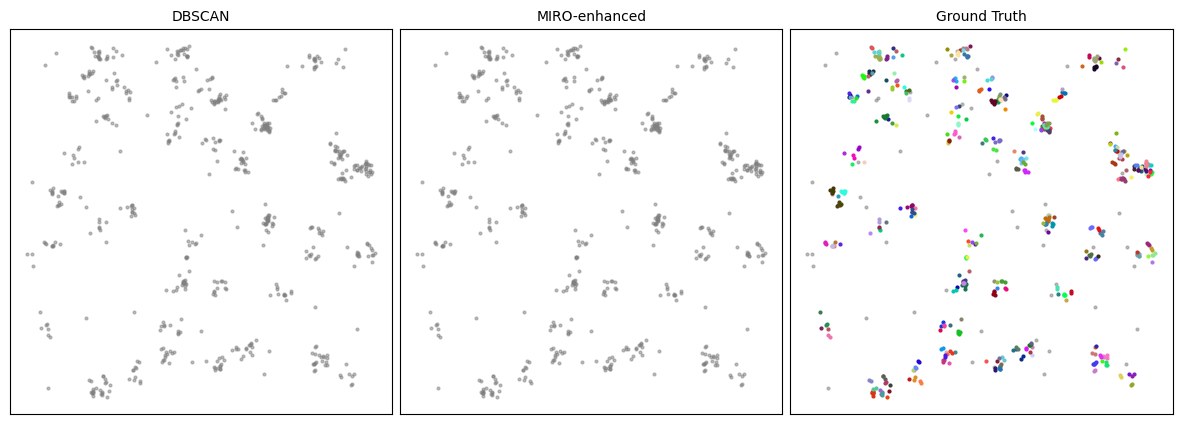

In [36]:
def plot_clustering_results(results):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Titles for each subplot
    titles = ["DBSCAN", "MIRO-enhanced", "Ground Truth"]

    # Loop through each clustering method and visualize results
    for i, c in enumerate(["clustering-DBSCAN", "clustering-MIRO", "index"]):
        clustering = results[c].copy()
        ax[i].set_xticks([])  # Remove x-axis ticks for a cleaner plot
        ax[i].set_yticks([])  # Remove y-axis ticks for a cleaner plot
        ax[i].set_title(titles[i], fontsize=10)  # Set title for the subplot

        # Iterate through unique cluster labels
        for u in np.unique(clustering):
            if u == 0:  # Background points (label 0)
                ax[i].scatter(
                    results["x"][results[c] == u],  # x-coordinates of background points
                    results["y"][results[c] == u],  # y-coordinates of background points
                    s=4,  # Point size
                    c="gray",  # Background color
                    alpha=0.5,  # Transparency for background points
                )
            else:  # Clustered points
                ax[i].scatter(
                    results["x"][results[c] == u],  # x-coordinates of clustered points
                    results["y"][results[c] == u],  # y-coordinates of clustered points
                    s=4,  # Point size
                    color=np.random.rand(3),  # Random RGB color for each cluster
                )
    plt.subplots_adjust(wspace=0.02)  # Adjust spacing between subplots
    plt.show()


validation_image = vresults[
    vresults["set"] == np.random.choice(vresults["set"].unique())
].copy()
plot_clustering_results(validation_image)